## Sesión 4.2 Clasificación de texto con scikit-learn y TFIDF

En esta sesión vamos a ver cómo podemos desarrollar un clasificador de texto sencillo con la librería scikit y la representación de texto de la bolsa de palabras usando TFIDF y BM25.

Vamos a usar el dataset de la primera sesión que tiene etiquetado los tuits como positivos y negativos.

In [ ]:
# Instalamos las librerías necesarias y descargamos los recursos
!pip3 install -U scikit-learn
# Descargamos un fichero python con la implementación del BM25
!wget --no-check-certificate https://valencia.inf.um.es/valencia-tgine/BM25.py

# Descargamos el fichero datasetEspañol.csv
!wget --no-check-certificate https://valencia.inf.um.es/valencia-tgine/datasetEspañol.csv

--2024-10-24 18:03:39--  https://valencia.inf.um.es/valencia-tgine/BM25.py
Resolving valencia.inf.um.es (valencia.inf.um.es)... 155.54.204.133
Connecting to valencia.inf.um.es (valencia.inf.um.es)|155.54.204.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3049 (3.0K) [text/x-python]
Saving to: ‘BM25.py’

BM25.py             100%[===================>]   2.98K  --.-KB/s    in 0s      

2024-10-24 18:03:40 (482 MB/s) - ‘BM25.py’ saved [3049/3049]

--2024-10-24 18:03:40--  https://valencia.inf.um.es/valencia-tgine/datasetEspa%C3%B1ol.csv
Resolving valencia.inf.um.es (valencia.inf.um.es)... 155.54.204.133
Connecting to valencia.inf.um.es (valencia.inf.um.es)|155.54.204.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1953117 (1.9M) [text/csv]
Saving to: ‘datasetEspañol.csv’

datasetEspañol.csv  100%[===================>]   1.86M  1.97MB/s    in 0.9s    

2024-10-24 18:03:41 (1.97 MB/s) - ‘datasetEspañol.csv’ saved [1953117/1953117]


In [ ]:
import pandas
df = pandas.read_csv("datasetEspañol.csv",encoding="UTF-8")
df.tail()

,twitter_id,twitter_created_at,tweet,corpus,user,agreement,votes,score,label,__split
5954,1274324047581581316,2020-06-20 16:51:43,No me fío nada! ? en #estadodealarma demostrar...,Estado de alarma nacional (oficial),GuzmanitaMaria,100,1,-1,negative,test
5955,1274321386446733315,2020-06-20 16:41:08,@roldanfj1 @MikiyDuarte @diariocadiz @realDona...,Estado de alarma nacional (oficial),ByChanchi,100,1,-1,negative,train
5956,1274340519271858178,2020-06-20 17:57:10,"Con el fin del #EstadodeAlarma se acaban, tamb...",Estado de alarma nacional (oficial),Javiersilvestre,100,1,-1,negative,val
5957,1274367246979211269,2020-06-20 19:43:22,@horaciorlarreta. @AsisOberdan. @luisnovaresio...,Estado de alarma nacional (oficial),juliodebarna,100,1,-1,negative,train
5958,1274368625047220224,2020-06-20 19:48:51,En la última semana se han registrado 36 falle...,Estado de alarma nacional (oficial),mallorcadiario,100,1,-1,negative,train


## Apartado 1.1 División de conjunto de entrenamiento y test (Resuelto)

Dividimos entre conjunto de entrenamiento, test y validación de manera aleatoria

In [ ]:
p_train = 0.80 # Porcentaje de train.
p_test = 0.20 # Porcentaje de train.

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = p_test)

# Ponemos en lower_case los dos conjuntos de tweets
# Aquí se podría hacer un preprocesamiento como vimos en la sesión práctica 1
df_train.tweet = df_train.tweet.apply(lambda x: x.lower())
df_test.tweet = df_test.tweet.apply(lambda x: x.lower())

print("Ejemplos usados para entrenar: ", len(df_train))
print("Ejemplos usados para test: ", len(df_test))

Ejemplos usados para entrenar:  4767
Ejemplos usados para test:  1192


## Apartado 1.2 Generación de los modelos de BoW (Resuelto)
Generamos los modelos de bolsa de palabras usando el CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
# Pueden haber distintas opciones para crear el CountVectorizer() como eliminar las stopwords, usar ngramas, etc.
X_train_counts = count_vect.fit_transform(df_train.tweet)
X_train_counts.shape

(4767, 20824)

In [ ]:
# Consultamos cuál sería el índice de un término
count_vect.vocabulary_.get(u'coronavirus')


5069

### Modelo de TF, TFIDF y BM25
Vamos a probar cómo funcionan los distintos modelos tanto de TF, TFIDF y BM25. Para ello generaremos 3 modelos distintos para entrenamiento y validación.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Generamos primeramente el TF usando el parámetro "use_idf=false"
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(4767, 20824)

In [ ]:
# Calculamos el TFIDF ahora y lo guardamos en X_train_tfidf
tfidf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)
X_train_tfidf.shape

(4767, 20824)

In [ ]:
from BM25 import BM25Transformer
# Calculamos el BM25 ahora y lo guardamos en X_train_bm25
bm25_transformer = BM25Transformer().fit(X_train_counts)
X_train_bm25 = bm25_transformer.transform(X_train_counts)
X_train_bm25.shape

(4767, 20824)

### Entrenamos un mismo algoritmo de clasificación con los modelos
Entrenamos un algoritmo de clasificación el LinearSVM con TF, TFIDF y BM25

In [ ]:
from sklearn.svm import LinearSVC

# Entrenamos el modelo para TF y lo guardamos en clf_tf
clf_tf = LinearSVC(random_state=0, tol=1e-5, dual=True).fit(X_train_tf, df_train.label)

# Entrenamos el modelo para TFIDF y lo guardamos en clf_tfidf
clf_tfidf = LinearSVC(random_state=0, tol=1e-5, dual=True).fit(X_train_tfidf, df_train.label)

# Entrenamos el modelo para TF y lo guardamos en clf_bm25
clf_bm25 = LinearSVC(random_state=0, tol=1e-5, dual=True).fit(X_train_bm25, df_train.label)


Probamos ejemplos

In [ ]:
docs_new = ['no me fío del gobierno', 'aumentan los fallecidos','desciende la incidencia del virus']
X_new_counts = count_vect.transform(docs_new)
# Obtenemos los vectores para TF y los guardamos en X_new_tf
X_new_tf = tf_transformer.transform(X_new_counts)

# Obtenermos los vectores para TFIDF y los guardamos en X_new_tfidf
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Obtenemos los vectores para BM25 y los guardamos en X_new_bm25
X_new_bm25 = bm25_transformer.transform(X_new_counts)

# Predecimos entonces las categorías para TF y las guardamos en predicted_tf
predicted_tf = clf_tf.predict(X_new_tf)

# Predecimos entonces las categorías para TFIDF y las guardamos en predicted_tfidf
predicted_tfidf = clf_tfidf.predict(X_new_tfidf)

# Predecimos entonces las categorías para BM25 y las guardamos en predicted_bm25
predicted_bm25 = clf_bm25.predict(X_new_bm25)

# Imprimimos los textos y su predicción para TF
for doc, category_tf in zip(docs_new, predicted_tf):
  print('TF: %r => %s' % (doc, category_tf))

# Imprimimos los textos y su predicción para TFIDF
for doc, category_tfidf in zip(docs_new, predicted_tfidf):
  print('TFIDF: %r => %s' % (doc, category_tfidf))

# Imprimimos los textos y su predicción para BM25
for doc, category_bm25 in zip(docs_new, predicted_bm25):
  print('BM25: %r => %s' % (doc, category_bm25))

TF: 'no me fío del gobierno' => negative
TF: 'aumentan los fallecidos' => negative
TF: 'desciende la incidencia del virus' => positive
TFIDF: 'no me fío del gobierno' => negative
TFIDF: 'aumentan los fallecidos' => negative
TFIDF: 'desciende la incidencia del virus' => positive
BM25: 'no me fío del gobierno' => negative
BM25: 'aumentan los fallecidos' => negative
BM25: 'desciende la incidencia del virus' => positive


## Apartado 1.3 Creamos los modelos mediante pipeline
Para simplificar el código de creación de modelos se puede hacer creando un pipeline.

In [ ]:
from sklearn.pipeline import Pipeline
# Se pueden crear modelos mediante Pipeline
# Creamos el pipeline de TF con LinearSVC
clf_tf = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', TfidfTransformer(use_idf=False)),
    ('clf', LinearSVC(random_state=0, tol=1e-5)),])

# Creamos el pipeline de TFIDF con LinearSVC y lo guardamos en clf_tfidf
clf_tfidf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=0, tol=1e-5)),])


# Creamos el pipeline de BM25 con LinearSVC y lo guardamos en clf_bm25
clf_bm25 = Pipeline([
    ('vect', CountVectorizer()),
    ('bm25', BM25Transformer()),
    ('clf', LinearSVC(random_state=0, tol=1e-5)),])

# Entrenamos el modelo de TF con el conjunto de entrenamiento con sus etiquetas
clf_tf.fit(df_train.tweet, df_train.label)

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf.fit(df_train.tweet, df_train.label)

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25.fit(df_train.tweet, df_train.label)


Pipeline(steps=[('vect', CountVectorizer()), ('bm25', BM25Transformer()),
                ('clf', LinearSVC(random_state=0, tol=1e-05))])

Evaluamos el accuracy del test en los 3 algoritmos

In [ ]:
import numpy as np

# Evaluamos el TF
predicted_tf = clf_tf.predict(df_test.tweet)
accuracy_tf = np.mean(predicted_tf == df_test.label)

print("Resultados TF ----- Accuracy:", accuracy_tf)
from sklearn import metrics
print(metrics.classification_report(df_test.label, predicted_tf))

# Evaluamos el TFIDF
predicted_tfidf = clf_tfidf.predict(df_test.tweet)
accuracy_tfidf = np.mean(predicted_tfidf == df_test.label)

print("Resultados TFIDF ----- Accuracy:", accuracy_tfidf)
from sklearn import metrics
print(metrics.classification_report(df_test.label, predicted_tfidf))

# Evaluamos el BM25
predicted_bm25 = clf_bm25.predict(df_test.tweet)
accuracy_bm25 = np.mean(predicted_bm25 == df_test.label)

print("Resultados BM25 ----- Accuracy:", accuracy_bm25)
from sklearn import metrics
print(metrics.classification_report(df_test.label, predicted_bm25))

Resultados TF ----- Accuracy: 0.8087248322147651
              precision    recall  f1-score   support

    negative       0.72      0.63      0.67       371
    positive       0.84      0.89      0.86       821

    accuracy                           0.81      1192
   macro avg       0.78      0.76      0.77      1192
weighted avg       0.80      0.81      0.81      1192

Resultados TFIDF ----- Accuracy: 0.8154362416107382
              precision    recall  f1-score   support

    negative       0.72      0.66      0.69       371
    positive       0.85      0.89      0.87       821

    accuracy                           0.82      1192
   macro avg       0.79      0.77      0.78      1192
weighted avg       0.81      0.82      0.81      1192

Resultados BM25 ----- Accuracy: 0.8187919463087249
              precision    recall  f1-score   support

    negative       0.73      0.66      0.69       371
    positive       0.85      0.89      0.87       821

    accuracy                  

## Apartado 1.4 Imprimimos las matrices de confusión
Para que se vean más bonitas podemos instalar las librerías matplotlib y seaborn

In [ ]:
!pip3 install -U matplotlib
!pip3 install -U seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


<Axes: >

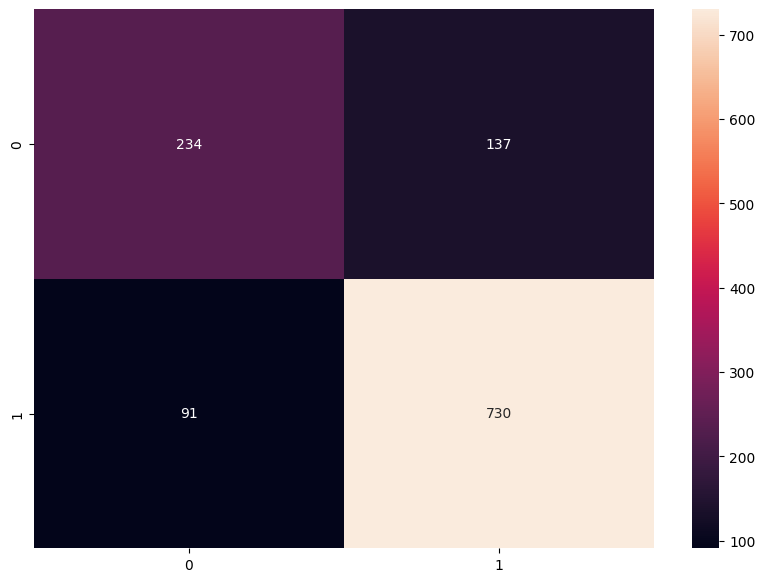

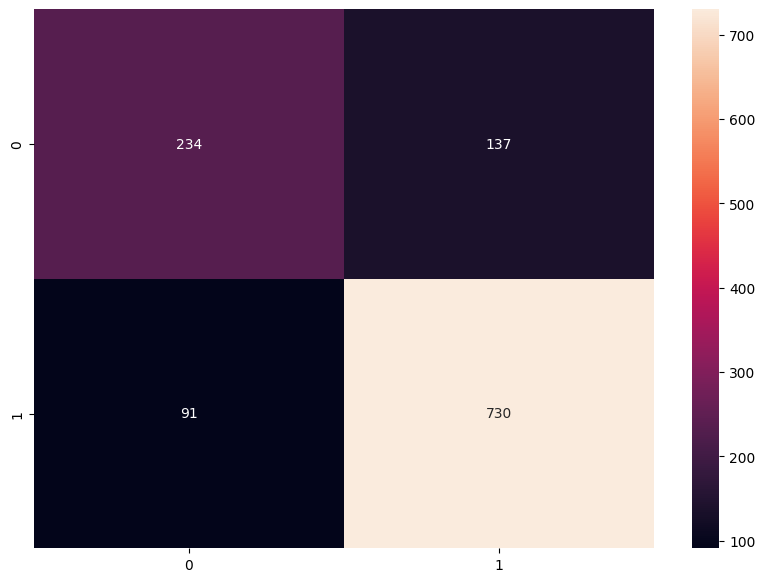

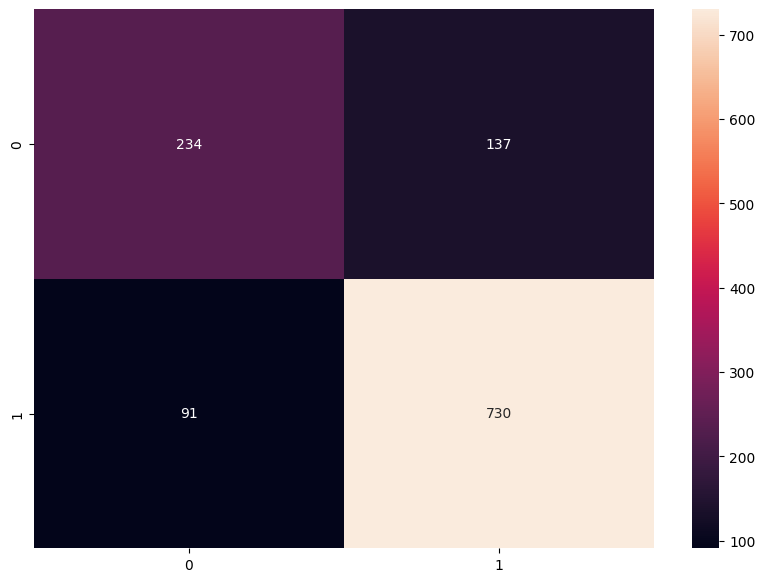

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Pintamos la matriz de confusión de TF
array_tf = metrics.confusion_matrix(df_test.label, predicted_tf)
df_cm_tf = pd.DataFrame(array_tf)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_tf, annot=True, fmt="d")

# Pintamos la matriz de confusión de TFIDF
array_tfidf = metrics.confusion_matrix(df_test.label, predicted_tfidf)
df_cm_tfidf = pd.DataFrame(array_tfidf)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_tf, annot=True, fmt="d")

# Pintamos la matriz de confusión de BM25
array_bm25 = metrics.confusion_matrix(df_test.label, predicted_bm25)
df_cm_bm25 = pd.DataFrame(array_tfidf)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_tf, annot=True, fmt="d")

## Apartado 1.5 - Guardamos y cargamos el modelo (Resuelto)


In [ ]:
import joblib

# Podemos gardar el modelo a algún archivo
modTF_file = "TF_model.pkl"
joblib.dump(clf_tf, modTF_file)

# Lo cargamos desde el fichero
TF_model = joblib.load(modTF_file)

# Volvemos a calcular el accuracy de los datos de test
score = TF_model.score(df_test.tweet, df_test.label)
print("Test accuracy: {0:.8f} %".format(100 * score))

# Otra forma de calcular el accuracy es
predicted_tf = TF_model.predict(df_test.tweet)
np.mean(predicted_tf == df_test.label)

# Probamos de nuevo los ejemplos para la clasificación
docs_new = ['no me fío del gobierno', 'aumentan los fallecidos','desciende la incidencia del virus']

# Predecimos
predicted_tf = TF_model.predict(docs_new)

# Imprimimos los textos y su predicción para TF
for doc, category_tf in zip(docs_new, predicted_tf):
  print('TF: %r => %s' % (doc, category_tf))

Test accuracy: 80.87248322 %
TF: 'no me fío del gobierno' => negative
TF: 'aumentan los fallecidos' => negative
TF: 'desciende la incidencia del virus' => positive


#Apartado 1.6 Creamos modelos con otros algoritmos de clasificación de scikit-learn

En la documentación de scikit-learn se describen multitud de clasificadores que se pueden utilizar https://scikit-learn.org/stable/supervised_learning.html

In [ ]:
from sklearn import ensemble
# Creamos y entrenamos modelos mediante Pipeline
# Creamos el pipeline de TF con LinearSVC
clf_tf = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', TfidfTransformer(use_idf=False)),
    ('clf', ensemble.RandomForestClassifier()),])

# Creamos el pipeline de TFIDF con LinearSVC y lo guardamos en clf_tfidf
clf_tfidf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', ensemble.RandomForestClassifier()),])


# Creamos el pipeline de BM25 con LinearSVC y lo guardamos en clf_bm25
clf_bm25 = Pipeline([
    ('vect', CountVectorizer()),
    ('bm25', BM25Transformer()),
    ('clf', ensemble.RandomForestClassifier()),])

# Entrenamos el modelo de TF con el conjunto de entrenamiento con sus etiquetas
clf_tf.fit(df_train.tweet, df_train.label)

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_tfidf.fit(df_train.tweet, df_train.label)

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25.fit(df_train.tweet, df_train.label)


Pipeline(steps=[('vect', CountVectorizer()), ('bm25', BM25Transformer()),
                ('clf', RandomForestClassifier())])

In [ ]:
# Evaluamos el TF
predicted_tf = clf_tf.predict(df_test.tweet)
accuracy_tf = np.mean(predicted_tf == df_test.label)

print("Resultados TF ----- Accuracy:", accuracy_tf)
from sklearn import metrics
print(metrics.classification_report(df_test.label, predicted_tf))

# Evaluamos el TFIDF
predicted_tfidf = clf_tfidf.predict(df_test.tweet)
accuracy_tfidf = np.mean(predicted_tfidf == df_test.label)

print("Resultados TFIDF ----- Accuracy:", accuracy_tfidf)
from sklearn import metrics
print(metrics.classification_report(df_test.label, predicted_tfidf))

# Evaluamos el BM25
predicted_bm25 = clf_bm25.predict(df_test.tweet)
accuracy_bm25 = np.mean(predicted_bm25 == df_test.label)

print("Resultados BM25 ----- Accuracy:", accuracy_bm25)
from sklearn import metrics
print(metrics.classification_report(df_test.label, predicted_bm25))

Resultados TF ----- Accuracy: 0.7726510067114094
              precision    recall  f1-score   support

    negative       0.77      0.39      0.52       371
    positive       0.77      0.95      0.85       821

    accuracy                           0.77      1192
   macro avg       0.77      0.67      0.68      1192
weighted avg       0.77      0.77      0.75      1192

Resultados TFIDF ----- Accuracy: 0.7718120805369127
              precision    recall  f1-score   support

    negative       0.74      0.41      0.53       371
    positive       0.78      0.94      0.85       821

    accuracy                           0.77      1192
   macro avg       0.76      0.67      0.69      1192
weighted avg       0.77      0.77      0.75      1192

Resultados BM25 ----- Accuracy: 0.7575503355704698
              precision    recall  f1-score   support

    negative       0.74      0.35      0.47       371
    positive       0.76      0.94      0.84       821

    accuracy                  